# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [35]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [36]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [37]:
rows = df.shape[0]
rows

294478

**c.** The number of unique users in the dataset.

In [38]:
unq_id = df['user_id'].nunique()
unq_id

290584

**d.** The proportion of users converted.

In [39]:
prop_converted =  df['converted'].mean()
prop_converted

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [40]:
df_t_n = df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]
df_t_n.shape[0]

1965

In [41]:
#The number of times when the "group" is control but "landing_page" is not an old_page.
df_t_n_2 = df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')]
df_t_n_2.shape[0]

1928

>The number of times the new_page and treatment don't match: 1928 + 1965 = 3893

**f.** Do any of the rows have missing values?

In [42]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

>No we do not have any missing values.

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



In [43]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df
df2 = df2.drop(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index)
df2 = df2.drop(df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].index)


In [44]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [45]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [46]:
unq_id = df2['user_id'].nunique()
unq_id

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [47]:
dup_user_id = df2[df2.duplicated(subset=['user_id'], keep=False)]['user_id']

In [48]:
dup_user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

In [49]:
dup_user_id = 773192

**c.** Display the rows for the duplicate **user_id**? 

In [50]:
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [51]:
# Remove one of the rows with a duplicate user_id..
df2 = df2.drop(1899)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == dup_user_id]['user_id'].count()

1

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [52]:
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [53]:
control_prob = df2[df2['group'] == 'control']['converted'].mean()
control_prob

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [54]:
treat_prob = df2[df2['group'] == 'treatment']['converted'].mean()
treat_prob

0.11880806551510564

In [55]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treat_prob - control_prob
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [56]:
df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>Old users converted with the probability of 0.1204 while new users converted with 0.1188 probability. So we cannot say that new treatment group users lead to more conversions.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  




> $H_0$ : $p_{old}$ >= $p_{new}$, 
$H_1$ : $p_{new} > p_{old}$. 

Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 





**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [57]:
df2['converted'].mean()

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [58]:
df2['converted'].mean()

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [59]:
num_of_new = df2[df2['group'] == 'treatment'].shape[0]
num_of_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [60]:
num_of_old = df2[df2['group'] == 'control'].shape[0]
num_of_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [61]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(2,num_of_new,0.11959708724499628)
new_page_converted

array([0, 1, 1, ..., 1, 0, 0])

In [62]:
p_new = new_page_converted.mean()
p_new

0.50189938751634433

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [63]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(2,num_of_old,0.11959708724499628)
old_page_converted

array([0, 1, 1, ..., 1, 0, 1])

In [64]:
p_old = old_page_converted.mean()
p_old

0.4973567190274929

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [65]:
diff2 = p_new-p_old
diff2

0.0045426684888514313


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [66]:
# Sampling distribution 
p_diffs=[]
for _ in range(10000):
      new_page_converted = np.random.choice([1, 0], num_of_new,replace = True,p = [df2['converted'].mean(), 1-df2['converted'].mean()])
      old_page_converted = np.random.choice([1, 0], num_of_old,replace = True,p = [df2['converted'].mean(), 1-df2['converted'].mean()])
      p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 



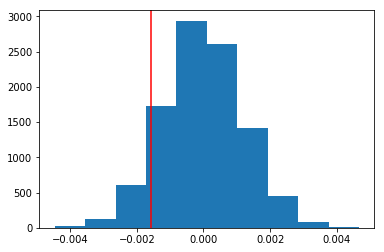

In [67]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.axvline(x = obs_diff, color = 'red')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [68]:
(p_diffs > obs_diff).mean()

0.90469999999999995

This value is called as **p value**. Since p values is greater than type 1 error rate which is 0.05, we do not enough evidence to reject H0



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [69]:
import statsmodels.api as sm
import scipy.stats
# number of conversions with the old_page
convert_old =  df2[(df2['landing_page'] == 'old_page') & (df2['converted'] == True)].shape[0]

# number of conversions with the new_page
convert_new = df2[(df2['landing_page'] == 'new_page') & (df2['converted'] == True)].shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]

# number of individuals who received new_page
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or **right-tailed** test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---



In [70]:
import statsmodels.api as sm
#import statsmodels.discrete.discrete_model
#import scipy.stats
#count = np.array([convert_old, convert_new])
#nobs = np.array([n_old, n_new])
#z_score, p_value = sm.stats.proportions_ztest(count,nobs,alternative='larger')
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value I computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>



>P value is 0.905 and $Z_{score}$ is -1.31.
Our p values are similar. Since our test is right tail test, $Z_{\alpha}$ is 1.645 and $Z_{score}$ < $Z_{\alpha}$ so we cannot reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

> Logistic Regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [71]:
df2['intercept'] = 1
df2[['ab_page_control','ab_page']] = pd.get_dummies(df['group'])

In [72]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page_control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [73]:
df2 = df2.drop('ab_page_control',1)

In [74]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [75]:
lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [76]:
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-02-05 06:06 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



> P-value associated with ab_page is 0.19. Specifically the p-value associated with each term in our model, is testing whether the population slope is equal to zero or not. H0: p1 = p2 H1: p1 != p2. It is two sided. However, in the second part tests whether pnew>pold. So our p values are different. It is one sided. This p value is still greater than 0.05 so we cannot reject null hypothesis.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> Adding other factors help us to analyze our result from different aspects. We can measure in a more realistic manner. Because in real life there is not only a factor that affects results. However, the problems that can arise are: A linear relationship may not exist, correlated errors, non-constant variance, outliers and multicollinearity.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 



In [77]:
# Read the countries.csv
df_co = pd.read_csv('countries.csv')

In [78]:
df_co.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [79]:
# Join with the df2 dataframe
df_merged = df2.join(df_co.set_index('user_id'), on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [80]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']]=pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


**h. Fit the model and obtain the results**<br> 


In [81]:
# Fit your model, and summarize the results
df_merged['intercept'] = 1
df_merged[['control', 'treatment']]=pd.get_dummies(df_merged['group'])
#lm = sm.OLS(df_merged['converted'],df_merged[['intercept','UK', 'US', 'control']])
#results = lm.fit()
#results.summary()
df_merged['UK_ab_page'] = df_merged['UK']*df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page']
logit3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

results = logit3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-02-05 06:06 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

In [82]:
#to exponentiate
np.exp(-0.0206), np.exp(-0.0057), np.exp(-0.0175),np.exp(0.0314),np.exp(-0.0469),

(0.97961073050325054,
 0.99431621417843319,
 0.9826522356650732,
 1.0318981806179213,
 0.95418281110072622)

> P values in the summary are all greater than 0.05. So we cannot reject null hypothesis. In other words we cannot say that our new landing page creates more conversion than its older version .
Let's dive into the statistical side of our analysis:
Conversion is 0.9943 times as likely on people lives in UK than US, holding all other variables constant.
Conversion is 0.9827 times as likely on people lives in CA than US, holding all other variables constant.
Conversion is 1.0319 times as likely on people lives in UK and be in a treatment group than US, holding all other variables constant.
Conversion is 0.9542 times as likely on people lives in CA and be in a treatment group than US, holding all other variables constant.
> If we interpret these statistical numbers, people who live in UK and see our old page tend to convert slightly more than people in US with same conditions. Also if we look overall conversion rate for UK and US, UK has 0.9943 times more chance for conversion. Since 0.9943 is slighty less than 1, former statement means that people who live in UK convert slightly less than US.  


<a id='finalcheck'></a>
## Final Check!


In [83]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0